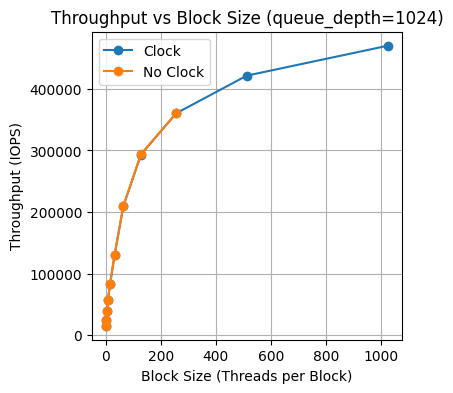

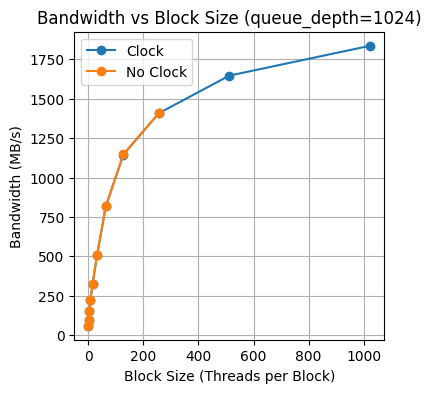

In [3]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Directory containing results
result_dir = "results"

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    # Determine if the file is 'clock' or 'noclock'
    if "_clock" in filename:
        params["clock"] = True
        filename_base = filename.replace("_clock", "")
    elif "_noclock" in filename:
        params["clock"] = False
        filename_base = filename.replace("_noclock", "")
    else:
        params["clock"] = None  # or handle as needed
        filename_base = filename
    for part in filename_base[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
# Key: (clock, block_size)
# Value: list of metrics
filtered_results = defaultdict(lambda: {"throughput": [], "bandwidth": []})

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                params = parse_parameters(filename)
                
                # Filter for queue_depth=1024
                if params.get("queue_depth") == 1024:
                    clock = params.get("clock")
                    block_size = params.get("block_size")
                    if clock is not None and block_size is not None:
                        key = (clock, block_size)
                        filtered_results[key]["throughput"].append(float(throughput_match.group(1)))
                        filtered_results[key]["bandwidth"].append(float(bandwidth_match.group(1)))

# Aggregate data for plotting
# Structure: {config: {block_size: average_metric}}
aggregated_throughput = defaultdict(dict)
aggregated_bandwidth = defaultdict(dict)

# Calculate average metrics
for (clock, block_size), metrics in filtered_results.items():
    avg_throughput = sum(metrics["throughput"]) / len(metrics["throughput"])
    avg_bandwidth = sum(metrics["bandwidth"]) / len(metrics["bandwidth"])
    config = "Clock" if clock else "No Clock"
    aggregated_throughput[config][block_size] = avg_throughput
    aggregated_bandwidth[config][block_size] = avg_bandwidth

# Prepare data for plotting
configs = ["Clock", "No Clock"]

# Initialize dictionaries to hold sorted block sizes and corresponding metrics
plot_data = {
    "Throughput": {
        "Clock": [],
        "No Clock": []
    },
    "Bandwidth": {
        "Clock": [],
        "No Clock": []
    }
}

block_sizes_per_config = {
    "Clock": [],
    "No Clock": []
}

# Collect sorted block sizes and corresponding metrics for each config
for config in configs:
    block_sizes = sorted(aggregated_throughput[config].keys())
    block_sizes_per_config[config] = block_sizes
    plot_data["Throughput"][config] = [aggregated_throughput[config][bs] for bs in block_sizes]
    plot_data["Bandwidth"][config] = [aggregated_bandwidth[config][bs] for bs in block_sizes]

# Plot Throughput
plt.figure(figsize=(4, 4))
for config in configs:
    if block_sizes_per_config[config]:  # Check if there is data to plot
        plt.plot(block_sizes_per_config[config], plot_data["Throughput"][config],
                 marker='o', label=config)
plt.title("Throughput vs Block Size (queue_depth=1024)")
plt.xlabel("Block Size (Threads per Block)")
plt.ylabel("Throughput (IOPS)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(plots_dir, "throughput_qd1024_clock_vs_noclock.svg"), transparent=True)
plt.show()

# Plot Bandwidth
plt.figure(figsize=(4, 4))
for config in configs:
    if block_sizes_per_config[config]:  # Check if there is data to plot
        plt.plot(block_sizes_per_config[config], plot_data["Bandwidth"][config],
                 marker='o', label=config)
plt.title("Bandwidth vs Block Size (queue_depth=1024)")
plt.xlabel("Block Size (Threads per Block)")
plt.ylabel("Bandwidth (MB/s)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(plots_dir, "bandwidth_qd1024_clock_vs_noclock.svg"), transparent=True)
plt.show()


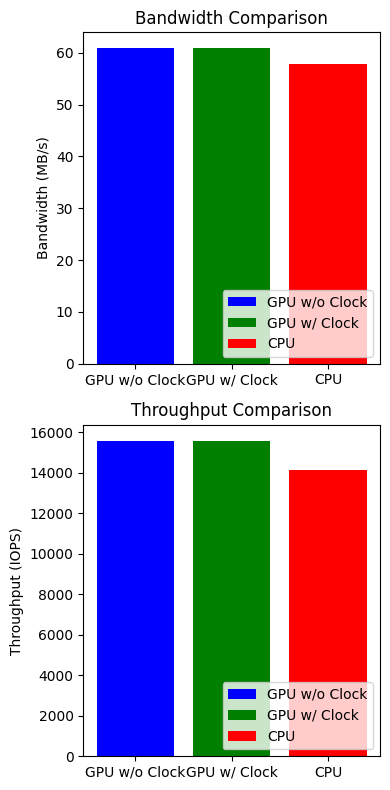

In [6]:
gpu_res = {
    "Bandwidth": 60.874221,
    "Throughput": 15583.800518
}
# no clock
# Kernel execution time: 6416.919922 ms
# Data transferred:      390.625000 MB
# Bandwidth:             60.874221 MB/s
# Throughput:            15583.800518 IOPS

gpu_res_clock = {
    "Bandwidth": 60.897543,
    "Throughput": 15589.771009
}
# Kernel execution time: 6414.462402 ms
# Data transferred:      390.625000 MB
# Bandwidth:             60.897543 MB/s
# Throughput:            15589.771009 IOPS


cpu_res = {
    "Bandwidth": 57.8784,
    "Throughput": 14130.5
}
# Throughput: 14130.5 IOPS
# Bandwidth: 57.8784 MB/s

from matplotlib import pyplot as plt

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(4, 8))

# Plot the bandwidth
ax[0].bar("GPU w/o Clock", gpu_res["Bandwidth"], color="blue", label="GPU w/o Clock")
ax[0].bar("GPU w/ Clock", gpu_res_clock["Bandwidth"], color="green", label="GPU w/ Clock")
ax[0].bar("CPU", cpu_res["Bandwidth"], color="red", label="CPU")
ax[0].set_ylabel("Bandwidth (MB/s)")
ax[0].set_title("Bandwidth Comparison")
ax[0].legend(loc="lower right")

# Plot the throughput
ax[1].bar("GPU w/o Clock", gpu_res["Throughput"], color="blue", label="GPU w/o Clock")
ax[1].bar("GPU w/ Clock", gpu_res_clock["Throughput"], color="green", label="GPU w/ Clock")
ax[1].bar("CPU", cpu_res["Throughput"], color="red", label="CPU")
ax[1].set_ylabel("Throughput (IOPS)")
ax[1].set_title("Throughput Comparison")
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.savefig("plots/comparison.svg", transparent=True)
plt.show()

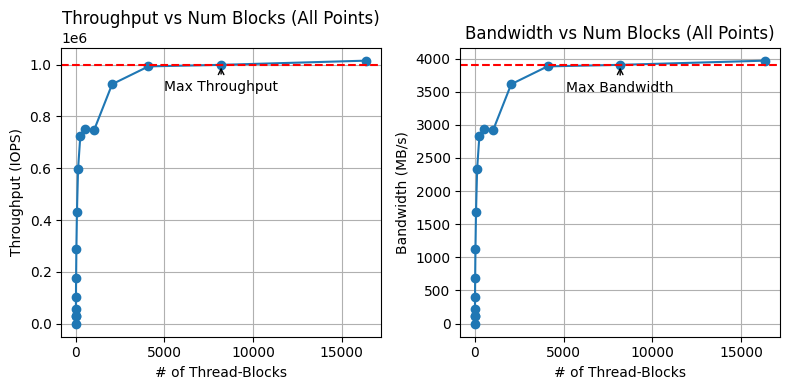

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

# Directory containing results
result_dir = "results"

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)


# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    for part in filename[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
results = defaultdict(list)

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                params = parse_parameters(filename)
                results[(params["queue_depth"], params["num_queues"], params["block_size"], params["num_blocks"])].append({
                    "kernel_time": float(kernel_time_match.group(1)) / 1000,  # Convert to seconds
                    "data_transferred": float(data_transferred_match.group(1)),
                    "bandwidth": float(bandwidth_match.group(1)),
                    "throughput": float(throughput_match.group(1)),
                    "page_size": params.get("page_size"),
                    "io_type": params.get("io_type"),
                    "io_method": params.get("io_method")
                })

# Group and plot results
parameters = ["queue_depth", "num_queues", "block_size", "num_blocks"]
metrics = ["kernel_time", "bandwidth", "throughput", "data_transferred"]
ylabel_map = {
    "kernel_time": "Runtime (s)",
    "bandwidth": "Bandwidth (MB/s)",
    "throughput": "IOPS",
    "data_transferred": "Data Transferred (MB)"
}

# sort results by block size 
results = dict(sorted(results.items(), key=lambda x: x[0][2]))

# get block sizes and their corresponding throughput and bandwidth
throughput_bandwidth = {}

for (queue_depth, num_queues, block_size, num_blocks), metrics_data_list in results.items():
    # get only where block size is 1 but num blokcs changes
    if block_size == 1 and queue_depth == 1024:
        throughput_bandwidth[num_blocks] = { "throughput": [], "bandwidth": [] }
        for metrics_data in metrics_data_list:
            throughput_bandwidth[num_blocks]["throughput"].append(metrics_data["throughput"])
            throughput_bandwidth[num_blocks]["bandwidth"].append(metrics_data["bandwidth"])
        
# sort by num blocks 
throughput_bandwidth = dict(sorted(throughput_bandwidth.items(), key=lambda x: int(x[0])))

import matplotlib.pyplot as plt

# Extract block sizes and their throughput/bandwidth
block_sizes = list(throughput_bandwidth.keys())
throughputs = [sum(v["throughput"]) for v in throughput_bandwidth.values()]
bandwidths = [sum(v["bandwidth"]) for v in throughput_bandwidth.values()]

# Add the origin point (0, 0) for both throughput and bandwidth
block_sizes.insert(0, 0)
throughputs.insert(0, 0)
bandwidths.insert(0, 0)

# Plot all points

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Throughput vs Block Size (All Points)
axes[0].plot(block_sizes, throughputs, label="Throughput", marker='o')
axes[0].set_title("Throughput vs Num Blocks (All Points)")
axes[0].set_xlabel("# of Thread-Blocks")
axes[0].set_ylabel("Throughput (IOPS)")
axes[0].grid()
# axes[0].legend()

# add horizontal line at 1m IOPS
axes[0].axhline(y=1000000, color='r', linestyle='--', label="1M IOPS")

# label the line
axes[0].annotate(
    "Max Throughput",
    xy=(block_sizes[14], 1000000),
    xytext=(block_sizes[14], 900000),  # Adjust offset as needed
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    ha='center'
)

# Bandwidth vs Block Size (All Points)
axes[1].plot(block_sizes, bandwidths, label="Bandwidth", marker='o')
axes[1].set_title("Bandwidth vs Num Blocks (All Points)")
axes[1].set_xlabel("# of Thread-Blocks")
axes[1].set_ylabel("Bandwidth (MB/s)")
axes[1].grid()
# axes[1].legend()

# add horizontal line at 4GB
max_band = 1000000 * 4096 / 1024 / 1024
axes[1].axhline(y=max_band, color='r', linestyle='--', label="4GB/s")
# label the line
axes[1].annotate(
    "Max Bandwidth",
    xy=(block_sizes[14], max_band),
    xytext=(block_sizes[14], 3500),  # Adjust offset as needed
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    ha='center'
)

plt.tight_layout()
plt.savefig("plots/performance_all_block.svg", transparent=True)
plt.show()

        

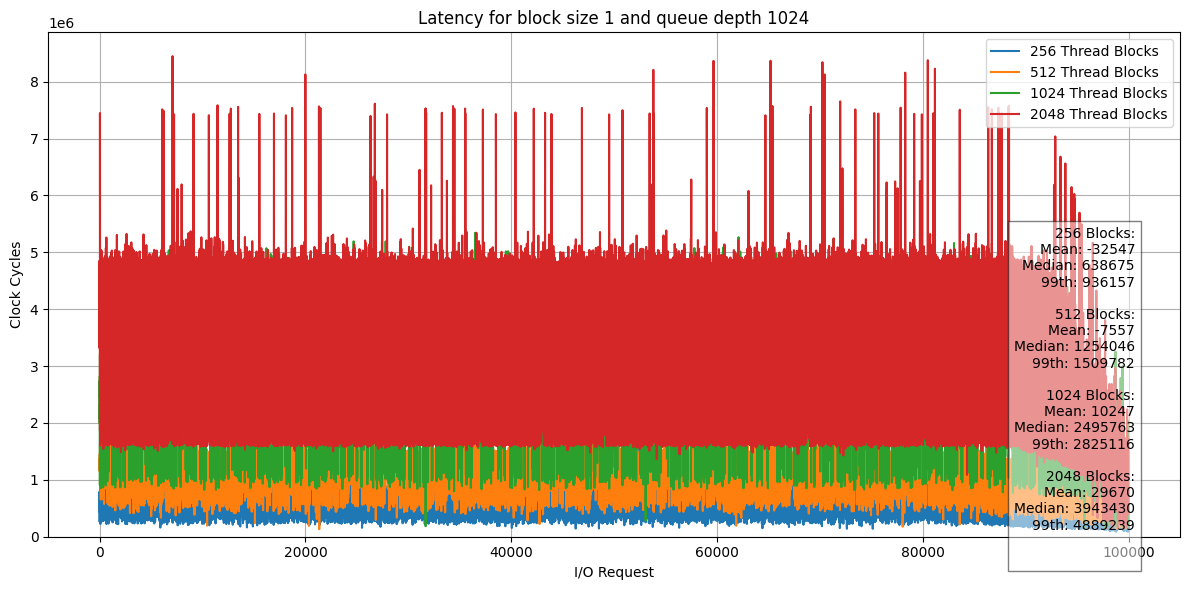

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import numpy as np

# Directory containing results
result_dir = "results"
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    for part in filename[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
results = defaultdict(list)

def get_last_latencies(content, block_size=10):
    lines = content.split("\n")
    
    # Remove empty strings and strip whitespace
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Extract the last 'block_size' lines
    return cleaned_lines[-block_size:]

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)
            
            params = parse_parameters(filename)
            
            # Extract latencies
            latencies = get_last_latencies(content, params.get("block_size", 10))
            for i in range(len(latencies)):
                latencies[i] = latencies[i].split(" ")
                latencies[i] = [int(x) for x in latencies[i] if x.isdigit()]
                latencies[i] = np.array(latencies[i])
                # Take difference between each element
                latencies[i] = np.diff(latencies[i])

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                results[(params["queue_depth"], params["num_queues"], params["block_size"], params["num_blocks"])].append({
                    "kernel_time": float(kernel_time_match.group(1)) / 1000,  # Convert to seconds
                    "data_transferred": float(data_transferred_match.group(1)),
                    "bandwidth": float(bandwidth_match.group(1)),
                    "throughput": float(throughput_match.group(1)),
                    "page_size": params.get("page_size"),
                    "io_type": params.get("io_type"),
                    "io_method": params.get("io_method"),
                    "latencies": latencies
                })


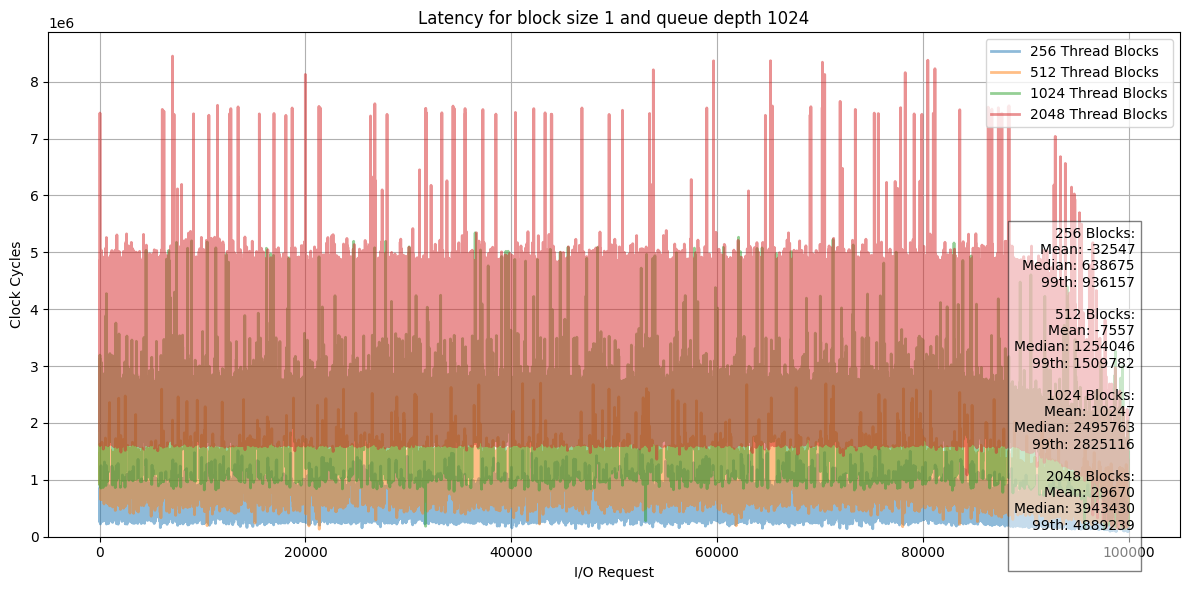

In [23]:

# Define desired parameters
desired_qd = 1024
desired_block_size = 1
desired_num_blocks = [256, 512, 1024, 2048]

# Initialize a dictionary to hold latencies for each num_blocks
filtered_latencies = {}

for num_blocks in desired_num_blocks:
    key = (desired_qd, None, desired_block_size, num_blocks)  # Assuming num_queues is irrelevant or varies
    # Since num_queues is part of the key, you might need to adjust if it's fixed or varies
    # Here, we collect all entries that match qd and block_size, and have the desired num_blocks
    matching_keys = [k for k in results.keys() if k[0] == desired_qd and k[2] == desired_block_size and k[3] == num_blocks]
    
    # Aggregate latencies from all matching entries
    all_latencies = []
    for mk in matching_keys:
        for entry in results[mk]:
            all_latencies.extend(entry["latencies"])
    
    # Convert list of arrays to a single array
    if all_latencies:
        concatenated = np.concatenate(all_latencies)
        filtered_latencies[num_blocks] = concatenated
    else:
        print(f"No data found for num_blocks={num_blocks}")

# Plot the latencies
plt.figure(figsize=(12, 6))

for num_blocks, latencies in filtered_latencies.items():
    # Remove negative values
    latencies = latencies[latencies > 0]
    # Optionally, limit to the first 1000 values
    # latencies = latencies[:1000]
    
    plt.plot(latencies, label=f"{num_blocks} Thread Blocks", alpha=0.5, linewidth=2)

plt.title(f"Latency for block size {desired_block_size} and queue depth {desired_qd}")
plt.xlabel("I/O Request")
plt.ylabel("Clock Cycles")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)

# Calculate and display statistics for each num_blocks
stats_text = ""
for num_blocks, latencies in filtered_latencies.items():
    mean = np.mean(latencies)
    median = np.median(latencies)
    percentile_99 = np.percentile(latencies, 99)
    
    # Round off to integer
    mean = int(mean)
    median = int(median)
    percentile_99 = int(percentile_99)
    
    stats_text += f"{num_blocks} Blocks:\nMean: {mean}\nMedian: {median}\n99th: {percentile_99}\n\n"

# Add the statistics text to the plot
plt.gcf().text(0.95, 0.05, stats_text, horizontalalignment='right', verticalalignment='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Save and show the plot
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "filtered_latencies.png"))
plt.show()


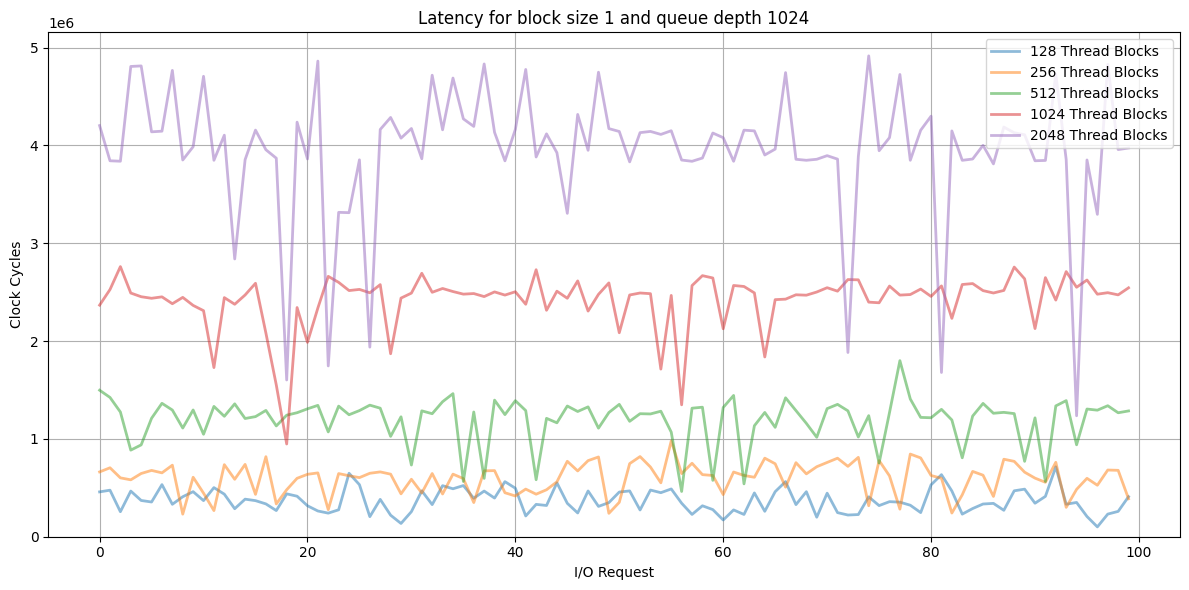

In [31]:
import os
import re
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import numpy as np

# Directory containing results
result_dir = "results"
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    for part in filename[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
results = defaultdict(list)

def get_last_latencies(content, block_size=10):
    lines = content.split("\n")
    
    # Remove empty strings and strip whitespace
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Extract the last 'block_size' lines
    return cleaned_lines[-block_size:]

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)
            
            params = parse_parameters(filename)
            
            # Extract latencies
            latencies = get_last_latencies(content, params.get("block_size", 10))
            for i in range(len(latencies)):
                latencies[i] = latencies[i].split(" ")
                latencies[i] = [int(x) for x in latencies[i] if x.isdigit()]
                latencies[i] = np.array(latencies[i])
                # Take difference between each element
                latencies[i] = np.diff(latencies[i])

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                results[(params["queue_depth"], params["num_queues"], params["block_size"], params["num_blocks"])].append({
                    "kernel_time": float(kernel_time_match.group(1)) / 1000,  # Convert to seconds
                    "data_transferred": float(data_transferred_match.group(1)),
                    "bandwidth": float(bandwidth_match.group(1)),
                    "throughput": float(throughput_match.group(1)),
                    "page_size": params.get("page_size"),
                    "io_type": params.get("io_type"),
                    "io_method": params.get("io_method"),
                    "latencies": latencies
                })

# Define desired parameters
desired_qd = 1024
desired_block_size = 1
desired_num_blocks = [128,256, 512, 1024, 2048]

# Initialize a dictionary to hold latencies for each num_blocks
filtered_latencies = {}

for num_blocks in desired_num_blocks:
    key = (desired_qd, None, desired_block_size, num_blocks)  # Assuming num_queues is irrelevant or varies
    # Since num_queues is part of the key, you might need to adjust if it's fixed or varies
    # Here, we collect all entries that match qd and block_size, and have the desired num_blocks
    matching_keys = [k for k in results.keys() if k[0] == desired_qd and k[2] == desired_block_size and k[3] == num_blocks]
    
    # Aggregate latencies from all matching entries
    all_latencies = []
    for mk in matching_keys:
        for entry in results[mk]:
            all_latencies.extend(entry["latencies"])
    
    # Convert list of arrays to a single array
    if all_latencies:
        concatenated = np.concatenate(all_latencies)
        filtered_latencies[num_blocks] = concatenated
    else:
        print(f"No data found for num_blocks={num_blocks}")

# Plot the latencies
plt.figure(figsize=(12, 6))

for num_blocks, latencies in filtered_latencies.items():
    # Remove negative values that happens because the 32bit clock wraps around every couple seconds inGPU
    latencies = latencies[latencies > 0]
    # Take random sample of 1000 values
    latencies = np.random.choice(latencies, 100)
    
    plt.plot(latencies, label=f"{num_blocks} Thread Blocks", alpha=0.8, linewidth=2)

plt.title(f"Latency for block size {desired_block_size} and queue depth {desired_qd}")
plt.xlabel("I/O Request")
plt.ylabel("Clock Cycles")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)

# Calculate and display statistics for each num_blocks
stats_text = ""
for num_blocks, latencies in filtered_latencies.items():
    mean = np.mean(latencies)
    median = np.median(latencies)
    percentile_99 = np.percentile(latencies, 99)
    
    # Round off to integer
    mean = int(mean)
    median = int(median)
    percentile_99 = int(percentile_99)
    
    stats_text += f"{num_blocks} Blocks:\nMean: {mean}\nMedian: {median}\n99th: {percentile_99}\n\n"

# Add the statistics text to the plot
# plt.gcf().text(0.95, 0.05, stats_text, horizontalalignment='right', verticalalignment='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Save and show the plot
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "filtered_latencies.png"))
plt.show()
